## Outline

Today we will show the Process of classificating Time-series starting with simple TS data using a sliding window approach
* First we show the preprocessing of a timeseries given as a continouus vector to a usable Dataloader
* Next we will show how to train a ConvNet using PyTorch on a Time-series classification Task
* We will show how to optimize parameters like Kernelsize, and number of kernels (i.e. number of features) etc. using grid search

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

from torch.utils.data import Dataset, ConcatDataset, DataLoader, random_split

# Time Series Classification Using CNN

The Data consist of three types of time series
* Step function
* Sine Wave
* Sawtooth Wave

To make it more difficult for the classification, a strong noise is added to the functions

In [4]:
def get_ts_steps(n, m, noise):
    """Sample a simple random two-class time series"""
    s = np.random.random((n)) * noise - noise / 2
    k = int(len(s) / m)
    for i in range(m):
        if i % 2 == 0:
            continue
        s[k * i:k * (i + 1)] += +1
    return s

def get_ts_wave(n, m, noise):
    """Sample a simple random two-class time series"""
    x = np.sin(np.linspace(-np.pi, m*np.pi, n))
    s = np.random.random((n)) * noise - noise / 2
    return x+s

def get_Sawtooth_wave(n, m, noise):
    """Sample a simple random two-class time series"""
    s = np.random.random((n)) * noise - noise / 2 - 1
    k = int(len(s) / m)
    lin_func = lambda x: 2/k * x
    lin = lin_func(np.arange(k))
    for i in range(m):
        if i % 2 == 0:
            continue
        s[k * i:k * (i + 1)] += 1*lin
    return s

>First we generate long Timeseries with n = 50000 datapoints each

In [5]:
n = 10000 
m = 500
noise = .1

X_steps = get_ts_steps(n, m, noise)
X_wave = get_ts_wave(n, m, noise)
X_sawtooth = get_Sawtooth_wave(n, m, noise)

**1)** Plot first 200 points of each Timeseries

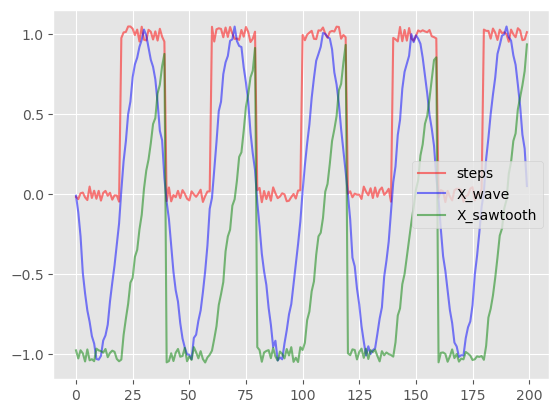

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(X_steps[:200], c='red', label='steps', alpha=0.5)
# plt.legend()
# plt.show()

plt.plot(X_wave[:200], c='blue', label='X_wave', alpha=0.5)
# plt.legend()
# plt.show()

plt.plot(X_sawtooth[:200], c='green', label='X_sawtooth', alpha=0.5)
plt.legend()
plt.show()

In [13]:
print(X_steps.shape)

(10000,)


**2)** Create a Dataloader for Training

>A dataloader is necessary for loading a consistent representation of values in the input space for the training, evaluation and test process. 
The idea is to train a model without dependecy of the length of the whole dataset. 
In this case we have 3 synthetic time series with 50000 data points. Fitting all the data at once into a model would lead to high computational requirements. 

>We will use a sliding window approach to split the data into smaller pieces and the length of the segments extracted here should be considered as a hyperparameter value. 

[Tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) gives an overview over the process. The Dataset class must implement three functions: 
` __init__`
` __len__`
` __getitem__`

for our case we need the additional function:
`split_sequence` to split the long time series into segments

In [40]:
class TimeSeriesData(Dataset):
    def __init__(self, X, y, sw):
        
        self.X = X # Time Series data
        self.y = y # class
        self.sw = sw # window size of the sliding window
        
    def __len__(self):
        
        # The __len__ function returns the number of samples in our dataset
        # hint: you need to take into account the window size s
        
        return len(self.X) - self.sw + 1
    
    def split_sequence(self, X, y, index):
        
        # The split_sequence class returns the time series vector from the given index 
        # up to the given index plus the window size 
        # Additionaly it gives the realted class
        
        return X[index:index + self.sw], y[index:index + self.sw][0]
    
    def __getitem__(self, idx):  
    
        # The __getitem__ function returns a sample from the dataset at the given index idx
        # It should return it as a torch.Tensor class
        x, y = self.split_sequence(self.X, self.y, idx)
        return x, y


**3)** Creating Dataloader for training, testing and validation

* Create Datasets for each Time series seperatly
* Concat the datasets using [ConcatDataset](https://pytorch.org/docs/stable/data.html)
* Split the DataSet using [random_split](https://pytorch.org/docs/stable/data.html)
* Create Dataloader using [DataLoader](https://pytorch.org/docs/stable/data.html)

In [35]:
sw = 50

steps_DS = TimeSeriesData(X_steps, y=np.ones(len(X_steps))*0, sw = sw) # Dataset for class 0, step_function
wave_DS = TimeSeriesData(X_wave, y=np.ones(len(X_steps))*1, sw = sw)   # Dataset for class 1, wave_function
sawtooth_DS = TimeSeriesData(X_sawtooth, y=np.ones(len(X_steps))*2, sw = sw) # Dataset for class 2, sawtooth-function

# concat the datasets
datasets = torch.utils.data.ConcatDataset([steps_DS, wave_DS, sawtooth_DS])

# split the dataset in trainset, valset and testset with a 70%, 15%, 15% split
trainset, valset, testset = torch.utils.data.random_split(dataset=datasets,lengths=[0.7, 0.15, 0.15])

# Create Dataloader for training, testing an valitation
batch_size = 13
training_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testing_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(valset, batch_size=batch_size, shuffle=True)


In [39]:
x_, y_ = next(iter(training_dataloader))
print(x_)
print(x_.shape)
print(y_)

7966
4429
8406
1387
3090
4502
1383
2994
4172
7073
790
735
3335
tensor([[ 0.3995,  0.5337,  0.6329,  0.8002,  0.8780,  0.9652,  0.9679,  1.0165,
          0.9569,  0.9985,  0.9348,  0.7834,  0.7300,  0.5921,  0.4611,  0.3495,
          0.2066,  0.0618, -0.1440, -0.3175, -0.3724, -0.5495, -0.6485, -0.8320,
         -0.8315, -0.9155, -0.9831, -1.0401, -0.9708, -0.9994, -0.8977, -0.8493,
         -0.7315, -0.6327, -0.4759, -0.3021, -0.2053, -0.0168,  0.0977,  0.3225,
          0.4653,  0.5639,  0.6974,  0.8338,  0.9079,  0.8923,  0.9751,  0.9885,
          0.9819,  0.9390],
        [ 0.9962,  1.0097,  1.0304,  1.0281,  1.0074,  1.0121,  1.0170,  1.0323,
          0.9987,  0.9933,  1.0172, -0.0291,  0.0294,  0.0134,  0.0412, -0.0459,
          0.0112,  0.0177, -0.0116,  0.0098,  0.0419,  0.0144, -0.0404,  0.0194,
         -0.0451,  0.0317,  0.0270, -0.0369, -0.0484, -0.0177, -0.0370,  0.9919,
          0.9811,  1.0396,  0.9555,  1.0374,  1.0329,  1.0344,  1.0007,  0.9644,
          0.9866, 

In [37]:
y_.shape

torch.Size([13])

**4)** Implement a CNN architecture

>Use one 1D Convolutional Layer with Relu activation and max pooling (kernel = 2). After the convolutional Layer one Linear layer need to be applied. Lastly the classification should be realized by a Sofmax Function <br>
<br>
hint: you need to take into account the different output dimensions, according to convolution and pooling outup <br>
<br>
Convolutional output ([link](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)): <br>
<br>
$$L_{out} = \left[\frac{L_{in} + 2\cdot padding - dilation\cdot(kernel\_size - 1) - 1}{stride} + 1\right]$$
<br>
<br>
padding = 0 <br>
stride = 1 <br>
dilation = 1 <br>
<br>
pooling output ([link](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool1d.html))

In [62]:
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, kernel_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.n_feature = n_feature
        self.kernel_size = kernel_size
        self.output_size = output_size  # ignore

        max_pool_in_features = (self.input_size - 1 - 1) + 1 # cf formula
        lin_in_features = ((max_pool_in_features - 1 - 1) + 1) * self.n_feature

        self.net = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=self.n_feature, kernel_size=self.kernel_size, stride=1, padding=0, dilation=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=self.kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False),

            nn.Linear(in_features=lin_in_features, out_features=3, bias=True, device=None, dtype=None),  # out_features = class prob
            nn.Softmax(1)
        )
        
    def forward(self, x):
        x = (x.reshape(-1, 1, self.input_size)).type('torch.DoubleTensor')
        print(x)
        return self.net(x)

    

**5)** Implement a training and testing function

In [55]:
def train(epoch, model, optimizer, loader_train):
    # eine Epoche
    model.train()
    losses = []
    for batch_idx, (data, target) in enumerate(loader_train):
        # Here you need to implement a training process, which uses the given optimizer 
        # calculates the loss and backprobs through the network
        # hint: take a look at previous implementations in other excersices
        output = model.forward(data)
        loss = nn.functional.cross_entropy(input=output, target=target)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    return np.mean(losses) # loss von epoche

def test(model, loader_test):
    # returns accuracy
    model.eval()
    losses = []
    for batch_idx, (data, target) in enumerate(loader_test):
        # Here you need to implement a training process, which uses the given optimizer 
        # calculates the loss and backprobs through the network
        # hint: take a look at previous implementations in other excersices
        output = model.forward(data)
        loss = torch.sum(output == target)
        losses.append(loss.item())
     
    return np.mean(losses) # acc von epoche

**6)** Implement a grid search optimization for the Numer of kernels ([`out_channels`](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html)) and the kernel size

>The next step is to implement a short grid search for the Number of features and the kernel size, use an algorithm like in excercise 10, optimization. You can use the previously defined training and testing functions to make you code look more clear


In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [63]:
n_feature = [1, 2, 3, 4, 5, 6]
kernel_size = [1, 3, 5, 7, 9]
epochs = 3
results_acc_list = []
results_loss_list = []


for feature in n_feature:
    results_acc_list = []
    results_loss_list = []
    for kernel in kernel_size:
        model = CNN(input_size=sw, n_feature=feature, kernel_size=kernel, output_size=3)
        sgd_optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        for epoch in range(epochs):
            results_loss = train(epoch, model, sgd_optimizer, training_dataloader)
            results_loss_list.append(results_loss)  # von Training
            results_acc = test(model, testing_dataloader)
            results_acc_list.append(results_acc)    # von Test Daten 
        

9231
9160
7636
4691
7164
5463
6878
9550
7055
5185
5767
4352
9929
tensor([[[-9.7362e-01, -1.0105e+00, -9.1530e-01, -8.6873e-01, -7.7427e-01,
          -6.1795e-01, -5.4078e-01, -3.6340e-01, -2.9211e-01, -6.7446e-02,
           5.7978e-02,  2.3123e-01,  3.2663e-01,  5.1477e-01,  6.2174e-01,
           7.3977e-01,  8.7887e-01,  9.5898e-01,  9.5636e-01,  9.7308e-01,
           9.5334e-01,  9.2511e-01,  9.5678e-01,  9.0296e-01,  7.4535e-01,
           7.0161e-01,  5.2576e-01,  3.8895e-01,  2.6625e-01,  1.0695e-01,
          -6.1505e-02, -1.9225e-01, -3.3040e-01, -5.1981e-01, -6.0920e-01,
          -7.1771e-01, -8.5751e-01, -8.7529e-01, -9.6080e-01, -9.5723e-01,
          -1.0439e+00, -9.6805e-01, -9.1445e-01, -8.3872e-01, -7.8265e-01,
          -6.9564e-01, -5.3785e-01, -3.6727e-01, -2.5734e-01, -4.9774e-02]],

        [[-2.9178e-02, -3.2660e-02, -4.5836e-02,  2.3955e-02, -2.0358e-02,
          -1.6814e-02,  2.5633e-02, -9.3083e-04, -8.2591e-03, -1.3288e-02,
           3.0745e-02,  1.2440e-

RuntimeError: expected scalar type Double but found Float

**7)** Visualize the optimization results

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(30, 60)
X, Y = np.meshgrid(n_feature, kernel_size)
ax.plot_surface(X, Y, np.vstack(results_loss_list).transpose(), cmap="plasma")
ax.set_xlabel('n_feature', fontsize=15, rotation=60)
ax.set_ylabel('kernel_size', fontsize=15, rotation=60)
plt.title('Loss')

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(30, 225)
X, Y = np.meshgrid(n_feature, kernel_size)
ax.plot_surface(X, Y, np.vstack(results_acc_list).transpose(), cmap="plasma")
ax.set_xlabel('n_feature', fontsize=15, rotation=60)
ax.set_ylabel('kernel_size', fontsize=15, rotation=60)
plt.title('Accuracy')

**8)** Final Results: Use the test Set to evaluate the Model with the best Hyperparameters

In [ ]:
####################
# Your Code Here   #
####################

**9)** What other hyperparameter can be optimized? 

>Discussion